In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import random
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

# 1. Import and clean the data

In [2]:
df = pd.read_csv('../data/interim/salary_skill_cleaned.csv')
df.head()

,Unnamed: 0,occupation,skill,importance,location,state,salary
0,0,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0
1,1,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0
2,2,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0
3,3,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0
4,4,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0


In [3]:
# Drop 'Unnamed: 0' and rename occupation_onet and annual to occupation and salary
df.drop(columns='Unnamed: 0', axis=1, inplace=True)
df.head()

,occupation,skill,importance,location,state,salary
0,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0
1,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0
2,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0
3,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0
4,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4774000 entries, 0 to 4773999
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   occupation  object 
 1   skill       object 
 2   importance  float64
 3   location    object 
 4   state       object 
 5   salary      float64
dtypes: float64(2), object(4)
memory usage: 218.5+ MB


There are 4,774,000 rows and 6 columns. Importance is the numerical measure of each skill. Only importance and salary are numeric values. 

# 2. Categorical features

In [5]:
# Number of unique occupations
occupations = df['occupation'].unique()
df['occupation'].nunique()

788

In [6]:
# List of all unique skills
df['skill'].unique()

array(['Reading Comprehension', 'Active Listening', 'Writing', 'Speaking',
       'Mathematics', 'Science', 'Critical Thinking', 'Active Learning',
       'Learning Strategies', 'Monitoring', 'Social Perceptiveness',
       'Coordination', 'Persuasion', 'Negotiation', 'Instructing',
       'Service Orientation', 'Complex Problem Solving',
       'Operations Analysis', 'Technology Design', 'Equipment Selection',
       'Installation', 'Programming', 'Operations Monitoring',
       'Operation and Control', 'Equipment Maintenance',
       'Troubleshooting', 'Repairing', 'Quality Control Analysis',
       'Judgment and Decision Making', 'Systems Analysis',
       'Systems Evaluation', 'Time Management',
       'Management of Financial Resources',
       'Management of Material Resources',
       'Management of Personnel Resources'], dtype=object)

In [7]:
# Number of unique skills
df['skill'].nunique()

35

In [8]:
# Number of unique locations
locations = df['location'].unique()
df['location'].nunique()

379

There are 35 unique skills, 379 unique locations and 788 unique occupations

# 3. Target feature (salary)

In [9]:
# Annual mean salary across all occupations
all_mean = np.mean(df['salary'])
all_std = np.std(df['salary'])
all_median = np.median(df['salary'])
print('Mean of all salaries: ' + str(round(all_mean, 2)))
print('Standard deviation: ' + str(round(all_std, 2)))

Mean of all salaries: 61028.51
Standard deviation: 32704.42


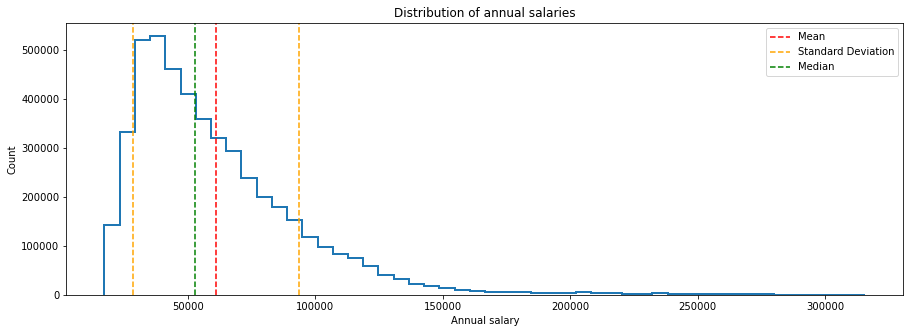

In [10]:
# Annual salary distribution for all occupations, with mean and one standard deviation represented with red and orange lines
# and the median in green
ax, fig = plt.subplots(figsize=(15, 5))
plt.hist(df['salary'], bins=50, histtype='step', linewidth = 2)
plt.axvline(x=all_mean, linestyle='--', color='red', label='Mean')
plt.axvline(x=all_mean - all_std, linestyle='--', color='orange', label='Standard Deviation')
plt.axvline(x=all_mean + all_std, linestyle='--', color='orange')
plt.axvline(x=all_median, linestyle='--', color='green', label='Median')
plt.xlabel('Annual salary')
plt.ylabel('Count')
plt.title('Distribution of annual salaries')
plt.legend()
plt;

The annual salary distribution is highly skewed to the right, indicating very few earners above $150,000.

## 3.1 Salary distributions for a few occuptions

In [11]:
# Funtion that plots the salary distribution for a given occupation
def salary_dist(occupation_list):
    new_slice = df[['occupation', 'location', 'salary']]
    new_slice = new_slice[~new_slice.duplicated()]
    new_slice[new_slice['occupation']==occupation_list].salary.hist(alpha=0.5)
    plt.xlabel('Salary')
    plt.ylabel('Count')
    plt.title('Distribution of salary for ' + occupation_list);

In [12]:
np.random.seed(142)
random_numbers=np.empty(25)
random_occupations=[]
for i in range(25):
    random_numbers[i] = np.random.randint(0, len(occupations)+1)
    random_occupations.append(occupations[int(random_numbers[i])])

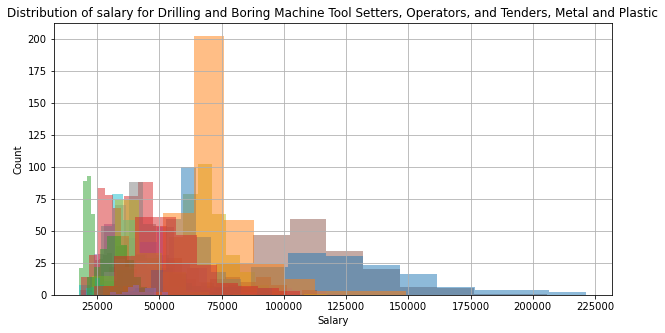

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
for i in range(len(random_occupations)):
    salary_dist(random_occupations[i])

## 3.2 Summary statistics

In [14]:
# Salary statistics for each occupation
occupation_stats = df.groupby('occupation')['salary'].describe()
occupation_stats.head()

,count,mean,std,min,25%,50%,75%,max
occupation,,,,,,,,
Accountants and Auditors,13860.0,71805.277778,9863.620539,29210.0,66627.5,71495.0,76517.5,111680.0
Actuaries,2205.0,113659.365079,16774.664509,61750.0,107290.0,115730.0,123980.0,156910.0
Acute Care Nurses,13230.0,72973.783069,15181.970944,27160.0,65150.0,70025.0,76660.0,149200.0
Adapted Physical Education Specialists,3115.0,63093.483146,14022.145306,28170.0,54990.0,64020.0,71430.0,98040.0
Adhesive Bonding Machine Operators and Tenders,1575.0,37033.777778,4603.571001,28230.0,33530.0,37090.0,39530.0,52880.0


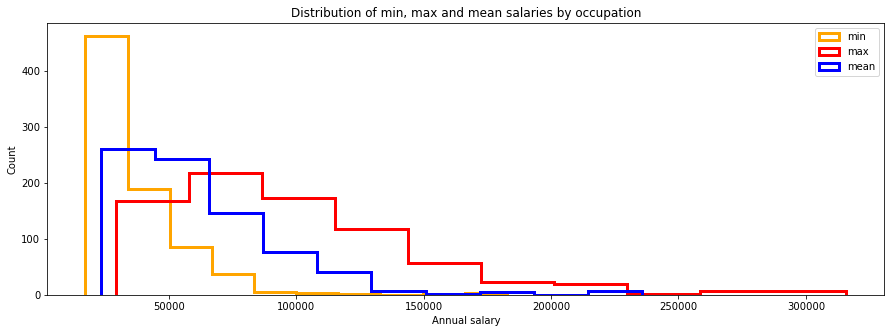

In [15]:
# Distribution of min, max and mean salaries by occupation
fig, ax = plt.subplots(figsize=(15,5))
plt.hist(occupation_stats['min'], histtype='step', linewidth=3, label='min', color='orange')
plt.hist(occupation_stats['max'], histtype='step', linewidth=3, label='max', color='red')
plt.hist(occupation_stats['mean'], histtype='step', linewidth=3, label='mean', color='blue')
plt.xlabel('Annual salary')
plt.ylabel('Count')
plt.title('Distribution of min, max and mean salaries by occupation')
plt.legend();

There is a LOT of overlap of min, max and mean salaries. There are occupations whose maximum earning is very low while we see there are occupations whose minimum annual income is higher than some of the maximum values.

In [16]:
# Salary statistics for each state
state_stats=df.groupby('state')['salary'].describe()
state_stats.head()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
AK,20860.0,72039.530201,31516.526027,24550.0,46557.5,69725.0,90020.0,240630.0
AL,126525.0,55418.735823,31268.225727,17440.0,33020.0,47620.0,67880.0,292110.0
AR,62755.0,53508.499721,29501.426893,19660.0,32930.0,45080.0,65500.0,247020.0
AZ,80605.0,58553.278333,30051.173346,25370.0,36760.0,49900.0,72180.0,279240.0
CA,362670.0,72027.821849,37267.193757,27710.0,42690.0,63030.0,92720.0,302040.0


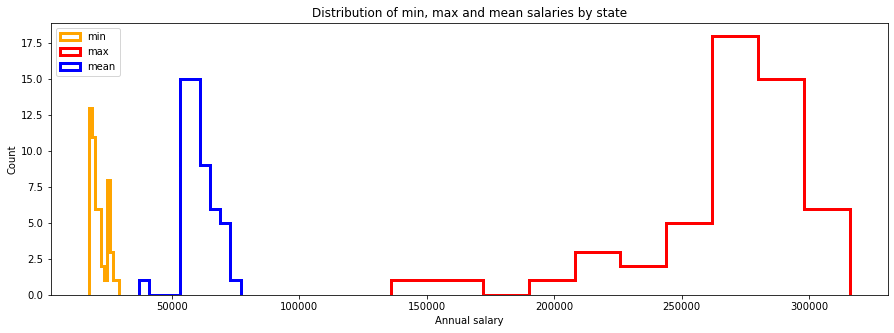

In [17]:
# Distribution of min, max and mean salaries by state
fig, ax = plt.subplots(figsize=(15,5))
plt.hist(state_stats['min'], histtype='step', linewidth=3, label='min', color='orange')
plt.hist(state_stats['max'], histtype='step', linewidth=3, label='max', color='red')
plt.hist(state_stats['mean'], histtype='step', linewidth=3, label='mean', color='blue')
plt.xlabel('Annual salary')
plt.ylabel('Count')
plt.title('Distribution of min, max and mean salaries by state')
plt.legend();

In the distributions minimum, mean and maximum salaries by state, there is not overlap like we saw above. Maximum salaries for each state clearly are higher than the mean and minimum values for ALL states. 

In [18]:
# Average income across all occupations, by state
income_average_per_state = df.groupby('state')['salary'].mean()
total_mean=income_average_per_state.mean()

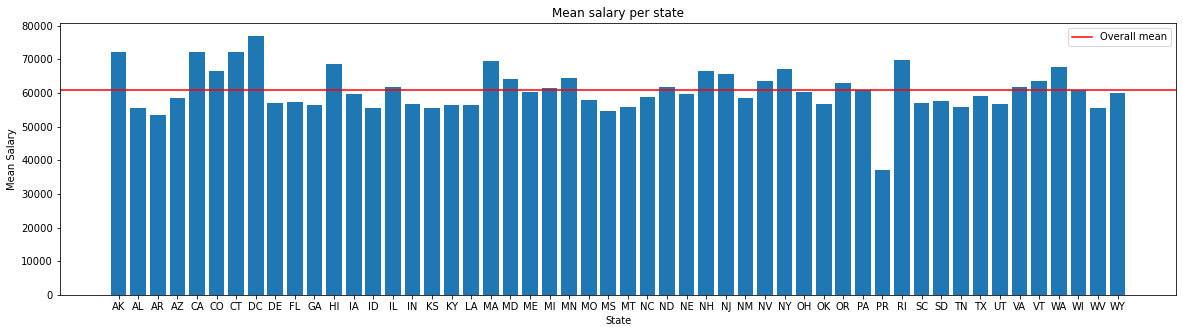

In [19]:
# Bar plot average income across all occupations by state with mean of all income represented with horizontal red line
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(income_average_per_state.index, income_average_per_state)
ax.axhline(y=total_mean, color='red', label='Overall mean')
ax.set_xlabel('State')
ax.set_ylabel('Mean Salary')
plt.title('Mean salary per state')
ax.legend();

# 4. Explore features (skills)

In [20]:
# Pivot table so that each skill is a column (variable)
skills = df.pivot_table(values='importance',index=['occupation', 'location', 'salary'],columns='skill').reset_index()
skills.head()

skill,occupation,location,salary,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
0,Accountants and Auditors,Abilene,70550.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
1,Accountants and Auditors,Aguadilla-Isabela,29630.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
2,Accountants and Auditors,Akron,75550.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
3,Accountants and Auditors,Albany,63940.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
4,Accountants and Auditors,Albany,70280.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75


In [21]:
skills.shape

(136400, 38)

In [22]:
df.shape

(4774000, 6)

In [23]:
# Number of rows for skills dataframe should be 35 times smaller than the original df because there are 35 skills
4774000/136400

35.0

In [24]:
skills = skills.groupby('occupation').mean()
skills.head()

skill,salary,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
occupation,,,,,,,,,,,,,,,,,,,,,
Accountants and Auditors,71805.277778,3.31,3.94,3.44,3.06,3.88,1.00,1.00,1.00,2.88,...,1.88,3.00,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
Actuaries,113659.365079,3.38,4.00,4.00,3.00,4.25,1.00,1.00,1.00,3.00,...,2.12,2.88,2.88,3.88,3.88,4.00,1.75,3.12,1.00,3.38
Acute Care Nurses,72973.783069,3.75,4.00,3.75,3.75,4.00,1.00,1.88,1.00,3.38,...,3.00,4.00,4.00,4.00,3.00,3.00,2.00,3.12,2.00,3.50
Adapted Physical Education Specialists,63093.483146,4.00,4.00,3.25,3.50,3.88,1.00,1.12,1.00,4.12,...,1.50,3.88,4.00,4.00,3.00,3.12,1.88,3.12,1.88,3.88
Adhesive Bonding Machine Operators and Tenders,37033.777778,2.62,3.12,2.75,3.00,2.88,2.88,2.12,1.12,2.25,...,1.50,2.25,2.88,3.12,2.75,2.12,1.25,3.00,3.00,2.75


In [25]:
skills.shape

(788, 36)

In [26]:
# Skill statistics
skills.describe().T

,count,mean,std,min,25%,50%,75%,max
skill,,,,,,,,
salary,788.0,62952.987672,31632.214177,23492.884615,40656.681548,55372.236842,78383.217666,235598.923077
Active Learning,788.0,3.097728,0.517948,1.880000,2.750000,3.120000,3.500000,4.120000
Active Listening,788.0,3.579734,0.457144,2.000000,3.120000,3.750000,4.000000,5.000000
Complex Problem Solving,788.0,3.192081,0.493043,1.880000,2.880000,3.120000,3.620000,4.380000
Coordination,788.0,3.111358,0.378096,2.000000,2.880000,3.000000,3.250000,4.250000
Critical Thinking,788.0,3.497094,0.452710,2.250000,3.120000,3.620000,3.880000,4.880000
Equipment Maintenance,788.0,1.741891,0.853970,1.000000,1.000000,1.380000,2.380000,4.250000
Equipment Selection,788.0,1.734302,0.695612,1.000000,1.000000,1.620000,2.250000,3.750000
Installation,788.0,1.252411,0.523319,1.000000,1.000000,1.000000,1.250000,4.750000


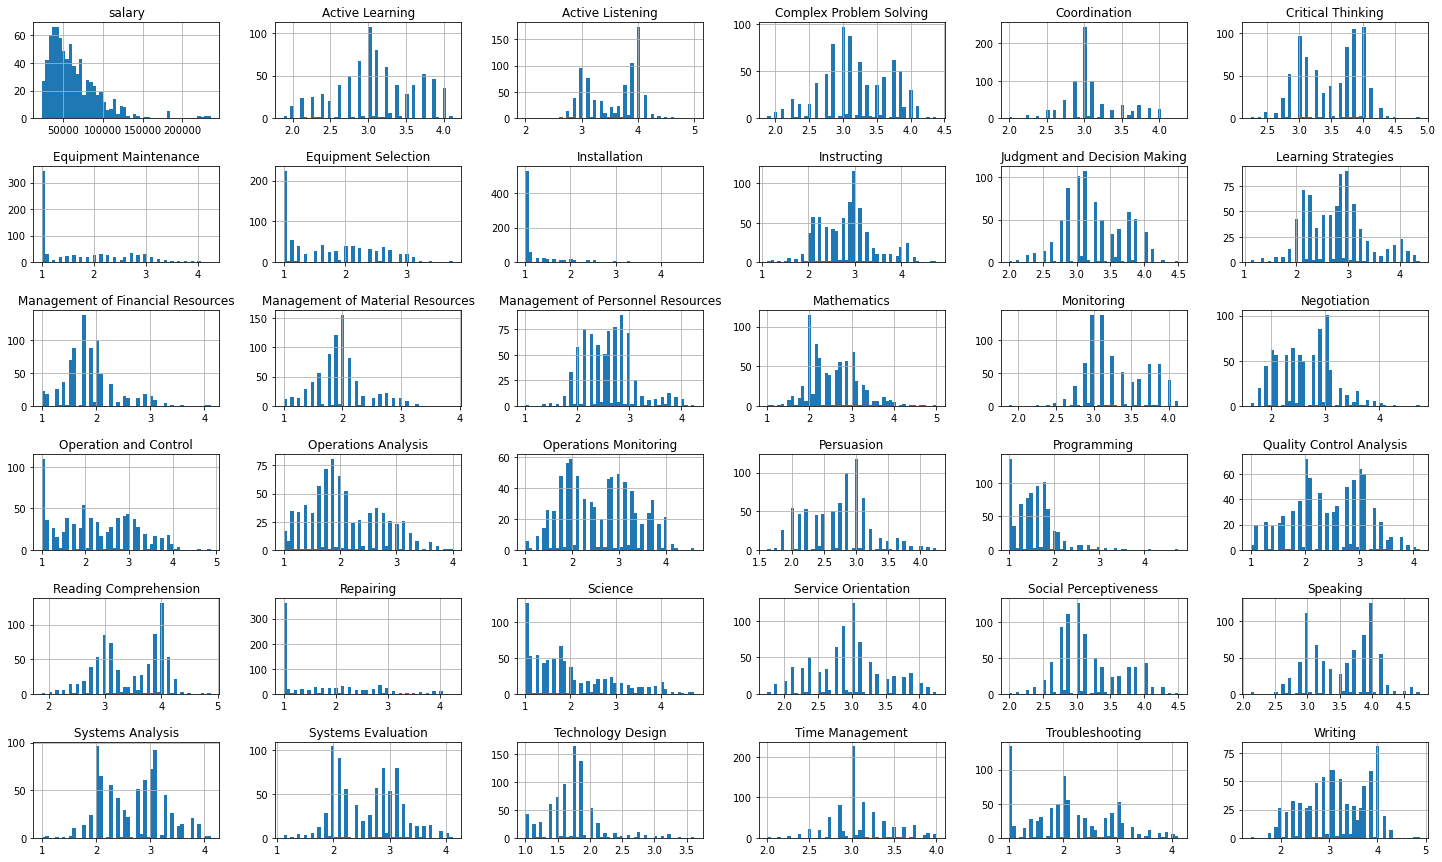

In [27]:
# Histograms of each variable in skills dataframe
skills.hist(figsize=(25, 15), bins=50)
plt.subplots_adjust(hspace=0.5);

Just looking at these histograms, we can see that Installation, Equipment Maintenance, Equipment Selection, and Repairing are highly skewed to the right. Most of their values are concentrated around 1.  

Most of the distributions above are bimodal. Time Managment and Service Orientation have the most normal distributions. Technology design and Programming have most of their values concentrated below 2. Science has a high value at 1 which means that science is not ranked as important for many occupations! We also see this features in Troubleshooting, Programming and Operations and Control.  

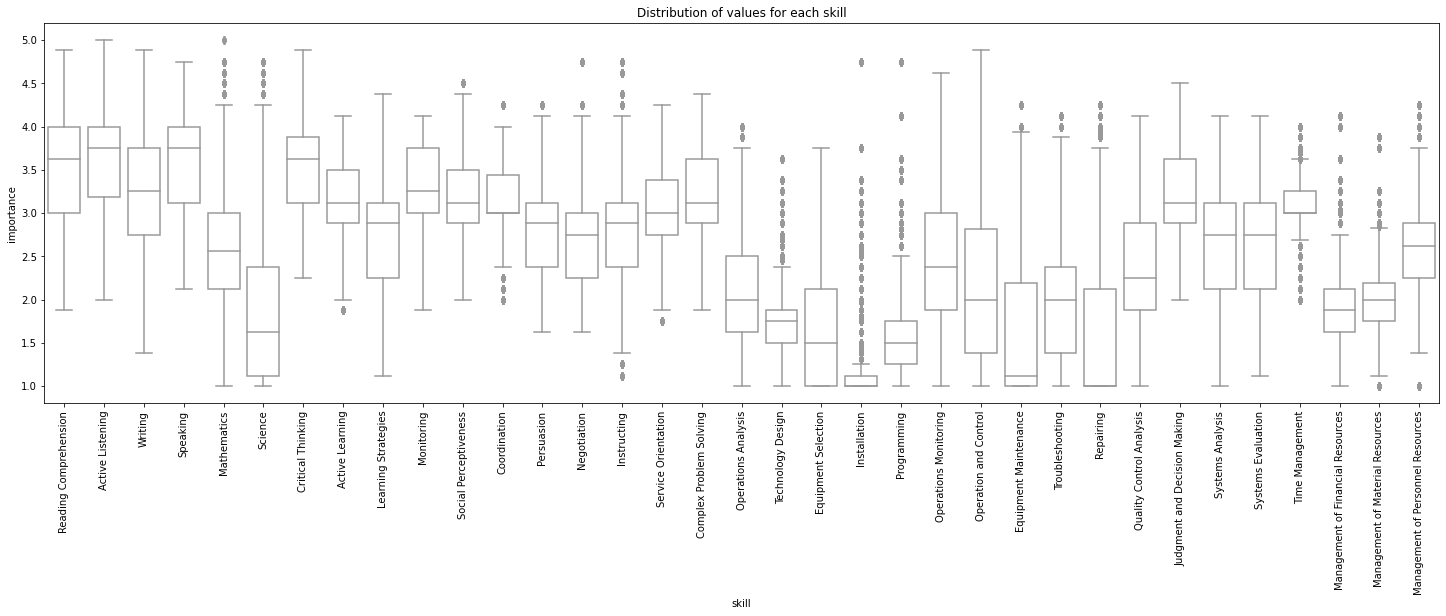

In [28]:
# Box plot of values for each skill
plt.subplots(figsize=(25,7))
sns.boxplot(x='skill', y='importance', data=df, color='white')
plt.xticks(rotation=90)
plt.title('Distribution of values for each skill');

From the boxplots we see that Installation is heavility concentrated at 1.0 with a very small range of values containted within the box and the whiskers of the plot with quite a few outliers. 

Equipment Selection, Equipment Maintenance, and Repairing seem to have a hight concentration of their values close to one (with IQR between 1 and 2. We will look at the correlation between these featurers later. I will drop these and installation column later on.

Systems analysis and Systems Evaluations have almost identical boxplots and distributions, so we will look at their correlation as well.

Programming and technology design have very short IQR (~0.5) with most values below 2 with many high outliers.

Time Managment as most it's values concentrated around 3.0, indicated a narrow normal distirbution. This is perhaps because average skill level in time management is very important for almost all occupations 

# 5. Relationship between target feature (salary) and variables (skills)

In [29]:
# List of features(skills) to plot vs target feature(salary)
features = [x for x in skills.columns]

In [30]:
len(features)

36

In [31]:
skills.shape

(788, 36)

In [32]:
skills[features].shape

(788, 36)

In [33]:
# Function to create scatter plots
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'salary', data=skills, alpha=0.5)
        ax.set(xlabel=col, ylabel='Salary')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

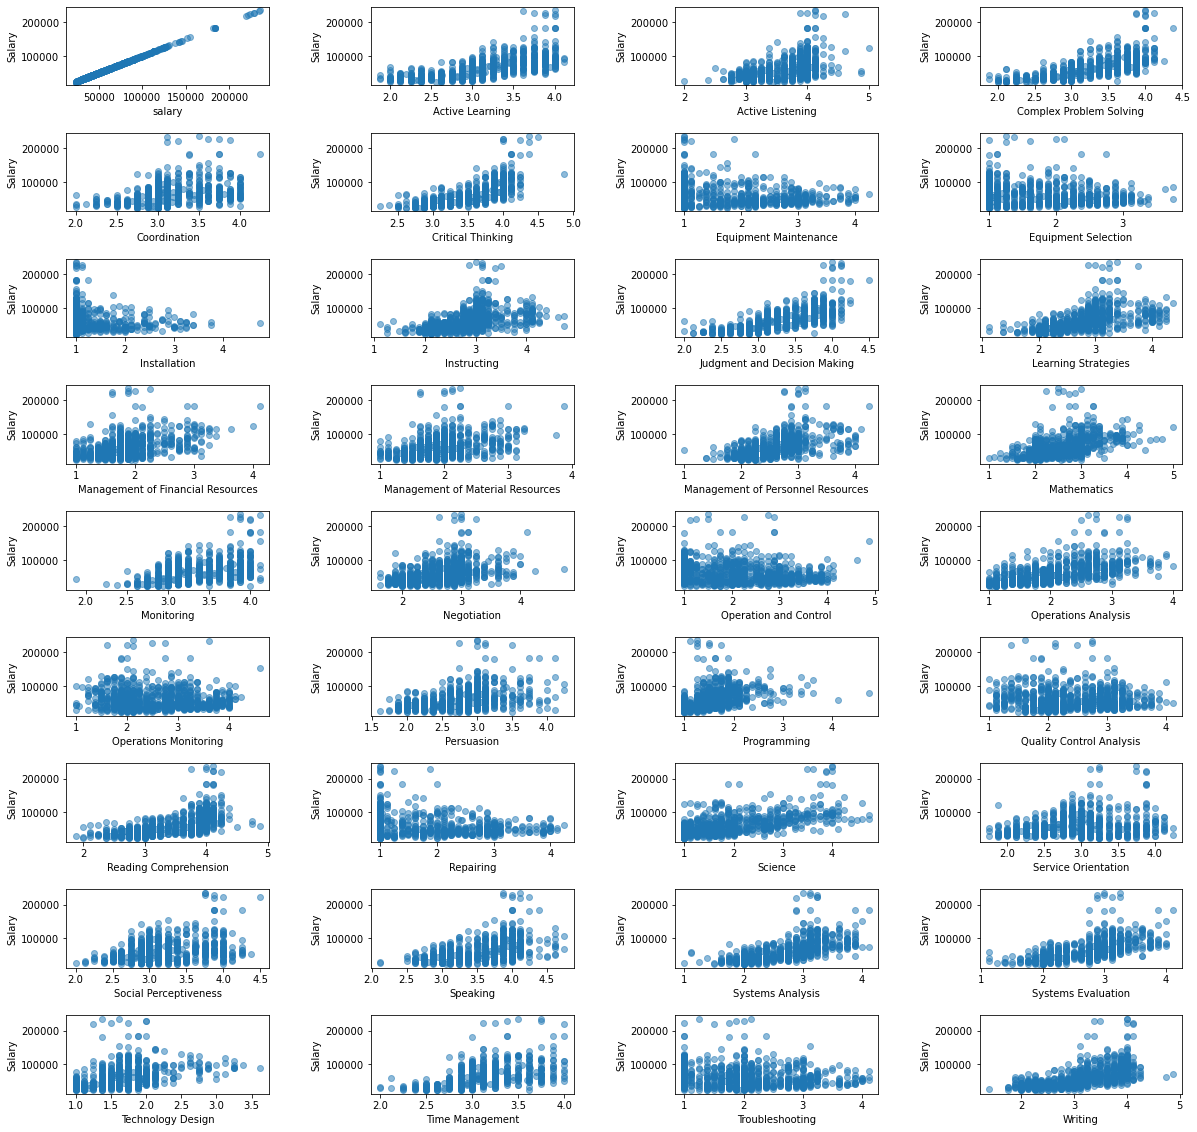

In [34]:
# Scatter plots of each skill vs salary
scatterplots(features, ncol=4, figsize=(20, 20));

Comments on scatter plots

ADD JITTER

# 6. Correlation between each feature

In [35]:
# Correlation matrix for skills
corr_matrix = skills.corr()
corr_matrix.head()

skill,salary,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
skill,,,,,,,,,,,,,,,,,,,,,
salary,1.000000,0.660258,0.540624,0.695754,0.404059,0.703217,-0.227445,-0.159001,-0.107845,0.475319,...,0.600575,0.230785,0.386537,0.525874,0.635770,0.641910,0.342260,0.504925,-0.155117,0.595306
Active Learning,0.660258,1.000000,0.779979,0.841820,0.563682,0.851168,-0.379772,-0.308917,-0.165427,0.781521,...,0.600306,0.491619,0.605780,0.774418,0.776263,0.783533,0.381528,0.623220,-0.325381,0.841135
Active Listening,0.540624,0.779979,1.000000,0.714368,0.595247,0.784760,-0.571947,-0.536559,-0.325628,0.667232,...,0.430593,0.658002,0.735272,0.904896,0.655864,0.653786,0.236556,0.597521,-0.524086,0.836147
Complex Problem Solving,0.695754,0.841820,0.714368,1.000000,0.553728,0.880541,-0.248656,-0.170138,-0.063429,0.671914,...,0.648549,0.384210,0.509369,0.687724,0.847852,0.853085,0.507358,0.626449,-0.164520,0.784869
Coordination,0.404059,0.563682,0.595247,0.553728,1.000000,0.561802,-0.340242,-0.297528,-0.191493,0.607045,...,0.213813,0.605299,0.724413,0.618526,0.548467,0.566446,0.194133,0.704224,-0.261627,0.506509


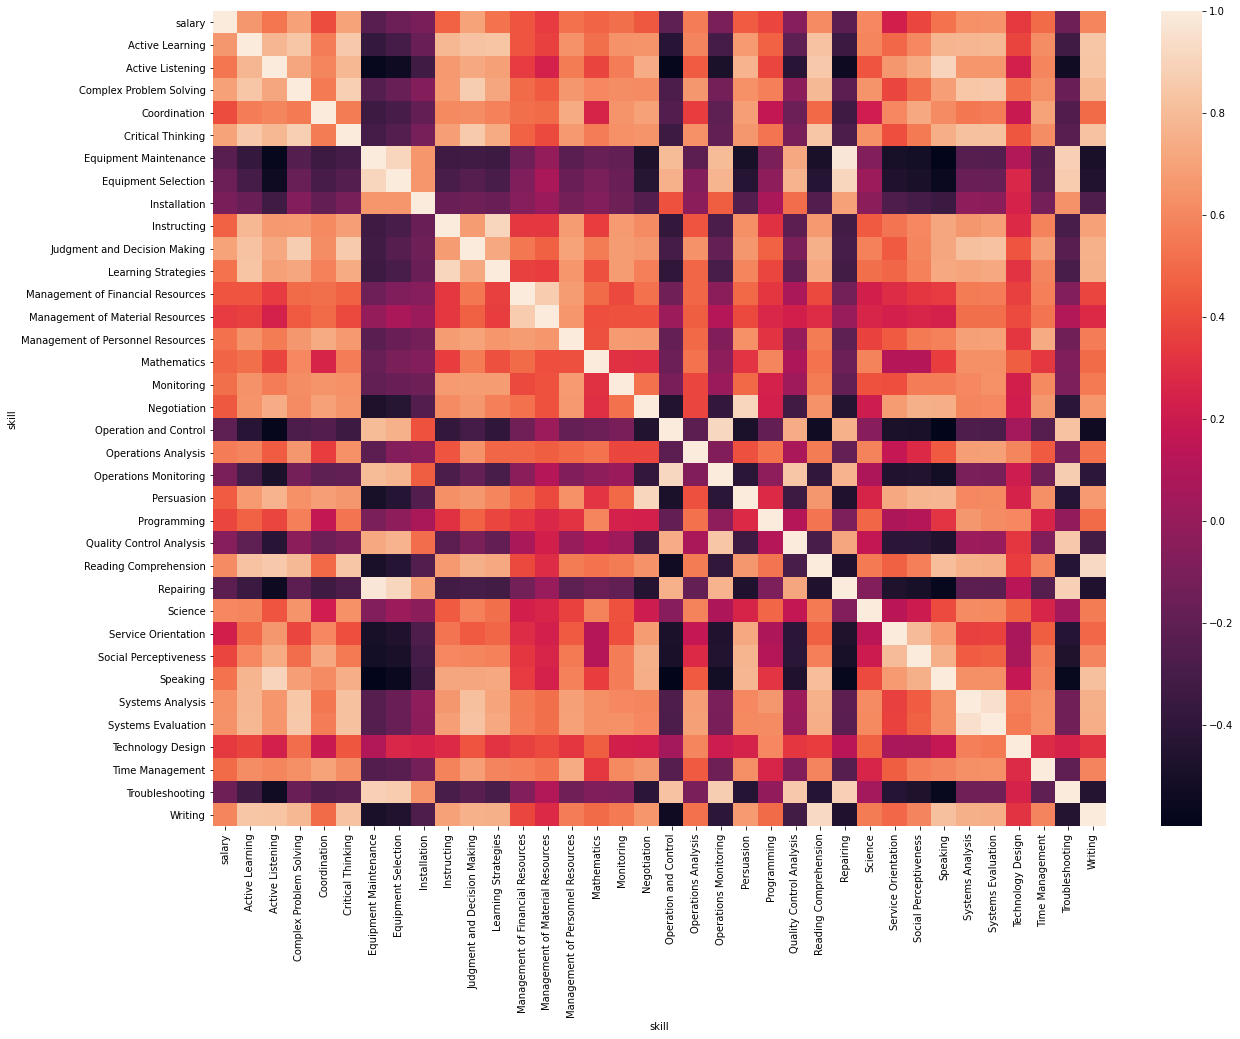

In [36]:
# Look at full heatmap of skills data
fig, ax=plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix);

Comment on full heatmap

## 6.1 Equipment-related skills

In [37]:
# Dataframe including skills related to intallation and maintaining equipment
equipment = skills[['Installation', 'Repairing', 'Equipment Maintenance', 'Equipment Selection']]
equipment.head()

skill,Installation,Repairing,Equipment Maintenance,Equipment Selection
occupation,,,,
Accountants and Auditors,1.00,1.0,1.00,1.00
Actuaries,1.00,1.0,1.00,1.00
Acute Care Nurses,1.00,1.0,1.00,1.88
Adapted Physical Education Specialists,1.00,1.0,1.00,1.12
Adhesive Bonding Machine Operators and Tenders,1.12,3.0,2.88,2.12


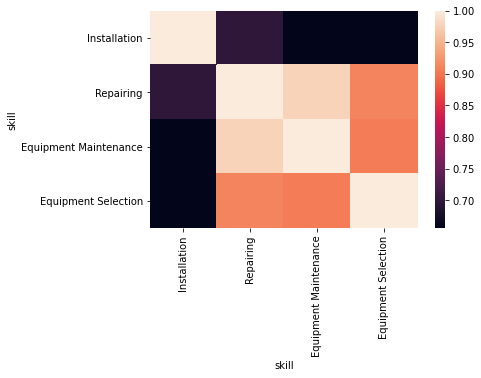

In [38]:
sns.heatmap(equipment.corr());

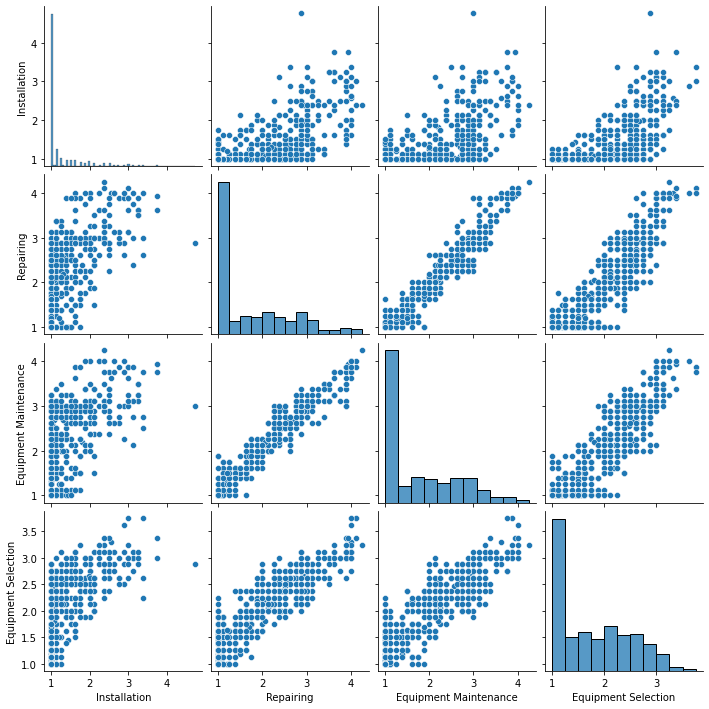

In [39]:
# Visualize correlation with scatter plots 
sns.pairplot(equipment);

There is no clear correlation between Installation and the other 3. Instead we will drop Installations based on looking at it's distribution and boxplots above and concluding there is very little information here that could be relevent to a wide range of occupations.

Equipment maintanace and Repairing seem most correlated but there is a clear positive correlation among these features. From the overall heatmap, we can also see that these features have close to zero correlation, maybe even slightly neagtively correlated with salary, our target feature!

In [40]:
# Drop Installation, Equipment Selection, Equipment Maintenance and Repairing
skills.drop(columns=equipment, inplace=True)
skills.shape

(788, 32)

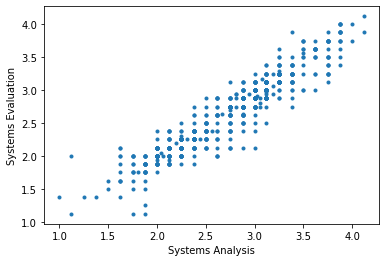

In [41]:
# Correlation between Systems Analysis and Systems Evaluation
plt.plot(skills['Systems Analysis'], skills['Systems Evaluation'], marker='.', linestyle='none')
plt.xlabel('Systems Analysis')
plt.ylabel('Systems Evaluation');

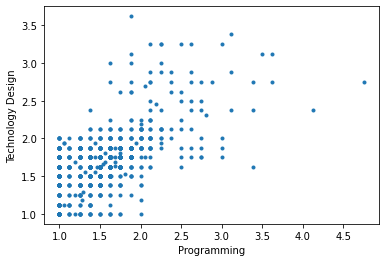

In [42]:
# Correlation between Programming and Technology Design
plt.plot(skills['Programming'], skills['Technology Design'], marker='.', linestyle='none')
plt.xlabel('Programming')
plt.ylabel('Technology Design');

In [43]:
# Correlation among skills relevent to learning and decision making
learning_skills = skills[['Critical Thinking', 'Complex Problem Solving', 'Active Learning', 
                          'Active Listening', 'Learning Strategies', 'Instructing', 'Judgment and Decision Making']]
learning_skills.head()

skill,Critical Thinking,Complex Problem Solving,Active Learning,Active Listening,Learning Strategies,Instructing,Judgment and Decision Making
occupation,,,,,,,
Accountants and Auditors,3.88,3.44,3.31,3.94,2.94,2.88,3.50
Actuaries,4.25,4.00,3.38,4.00,3.00,3.00,4.25
Acute Care Nurses,4.00,3.75,3.75,4.00,3.12,3.38,3.75
Adapted Physical Education Specialists,3.88,3.25,4.00,4.00,3.88,4.12,3.88
Adhesive Bonding Machine Operators and Tenders,2.88,2.75,2.62,3.12,2.25,2.25,2.62


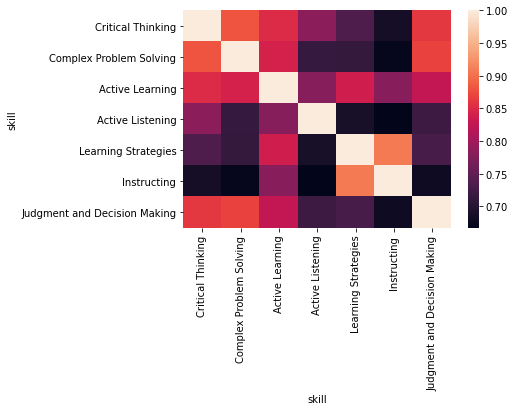

In [44]:
sns.heatmap(learning_skills.corr());

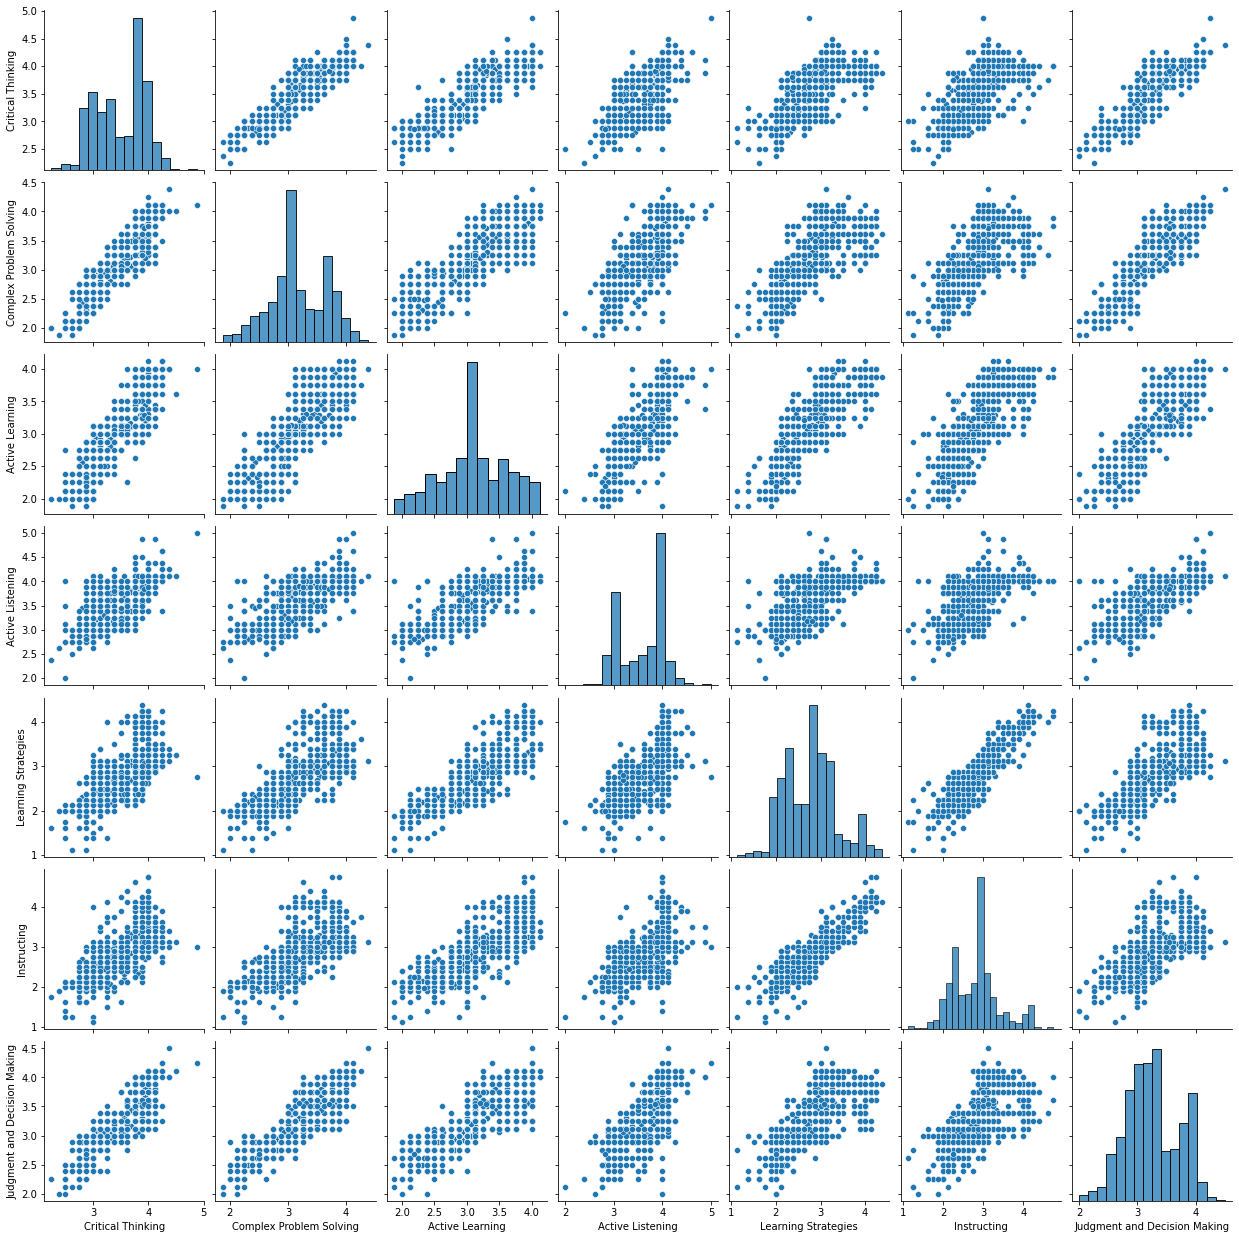

In [45]:
sns.pairplot(learning_skills);

There is correlation among many skills as seen above. Let's run a PCA to find the ideal dimensions for the problem.

In [46]:
skills_pca=PCA().fit(skills.set_index(['salary']))

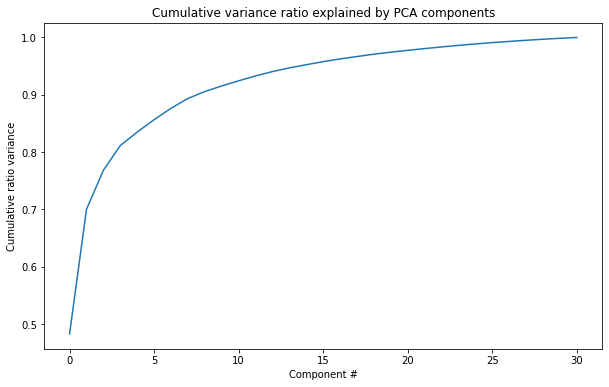

In [47]:
plt.subplots(figsize=(10, 6))
plt.plot(skills_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components');

Around 85 percent of variance is explained by the first 5 pca components and around 90 percent by the first pca 8 components.

In [48]:
skills_pca_x = skills_pca.transform(skills.set_index(['salary']))

In [49]:
skills_pca_x.shape

(788, 31)

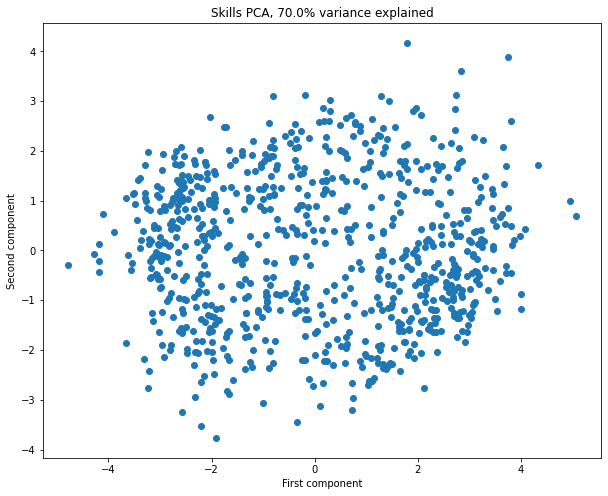

In [50]:
x = skills_pca_x[:, 0]
y = skills_pca_x[:, 1]
pc_var = 100 * skills_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Skills PCA, {pc_var:.1f}% variance explained');

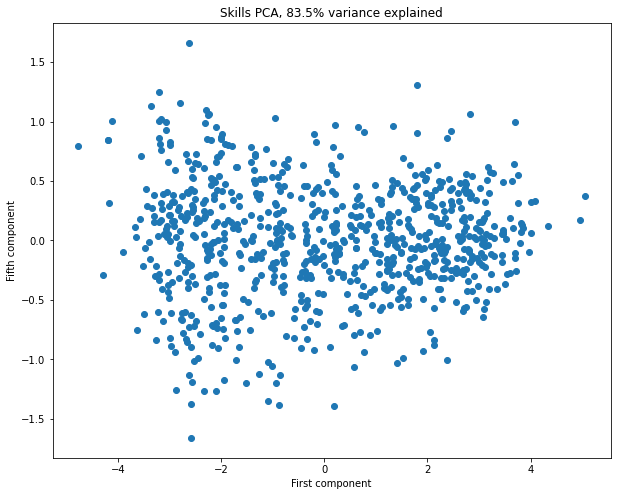

In [51]:
x = skills_pca_x[:, 0]
y = skills_pca_x[:, 4]
pc_var = 100 * skills_pca.explained_variance_ratio_.cumsum()[4]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Fifth component')
plt.title(f'Skills PCA, {pc_var:.1f}% variance explained');

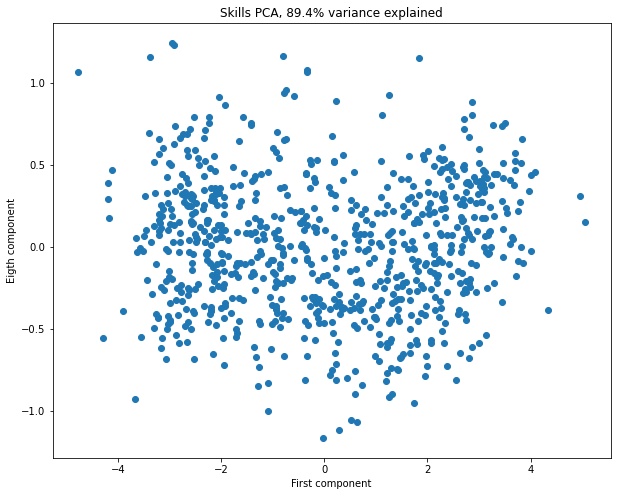

In [52]:
x = skills_pca_x[:, 0]
y = skills_pca_x[:, 7]
pc_var = 100 * skills_pca.explained_variance_ratio_.cumsum()[7]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Eigth component')
plt.title(f'Skills PCA, {pc_var:.1f}% variance explained');

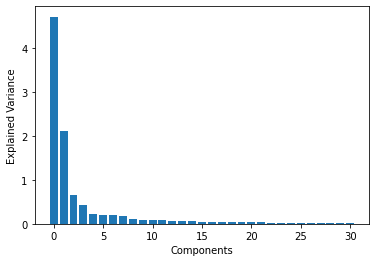

In [55]:
features=range(skills_pca.n_components_)
plt.bar(features, skills_pca.explained_variance_)
plt.xlabel('Components')
plt.ylabel('Explained Variance');